<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

In [2]:
# working dir
work_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/'

# bracken counts
brk_file = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/bracken_filt2.qs'

# GTDBr89 genome metadata
genome_meta_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/metadata_1per-GTDB-Spec_gte50comp-lt5cont_wtaxID_wPath.tsv'

# sample metadata
## filtered
#metadata_filt_file = file.path(work_dir, 'CurMetDat_metadata_filt-n1846.tsv')
## all 
base_in_dir = '/ebio/abt3_projects/small_projects/nyoungblut/public_data_retireval/'
metadata_file = file.path(base_in_dir, 'CurMetDat-metagenomes', 'files', 'metadata', 'Filtered_CurMetDat_ff.tsv')

# genes per COG-category
cog_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG/phenotype/genes-per-COGcat_UniRef90.tsv'


# params
threads = 8
my_seed = 68372

# Init

In [33]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(ape)
library(LeyLabRMisc)

In [5]:
df.dims()
setDTthreads(threads)
RhpcBLASctl::blas_set_num_threads(threads)
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/ 


# Load

In [6]:
# sample metadata
meta = Fread(metadata_file) 
meta %>% unique_n('Samples', Sample)
meta %>% unique_n('Subjects', subjectID)
meta %>% unique_n('Datasets', dataset_name)
meta

No. of unique Samples: 2943 
No. of unique Subjects: 2943 
No. of unique Datasets: 30 


dataset_name,Sample,subjectID,body_site,antibiotics_current_use,study_condition,disease,age,age_category,gender,⋯,glp_1,travel_destination,urea_nitrogen,disease_stage,uncurated_metadata,family_member,subject_n,samp_n,westernized,samps_per_study
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<lgl>,<int>
Bengtsson-PalmeJ_2015,TRAVELRES1,TRAVELRES1_2,stool,no,control,healthy,25,adult,female,⋯,NA,,NA,NA,,,1,1,TRUE,36
Bengtsson-PalmeJ_2015,TRAVELRES11,TRAVELRES11_12,stool,no,control,healthy,22,adult,female,⋯,NA,,NA,NA,,,1,1,TRUE,36
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZeeviD_2015,PNP_Validation_45,PNP_Validation_45,stool,no,control,healthy,NA,adult,,⋯,NA,,NA,NA,,,1,1,TRUE,446
ZeeviD_2015,PNP_Validation_46,PNP_Validation_46,stool,no,control,healthy,NA,adult,,⋯,NA,,NA,NA,,,1,1,TRUE,446


In [26]:
# Bracken count table
brk = qs::qread(brk_file, nthreads=threads) %>%
    mutate.(name = gsub(' ', '_', name)) %>%
    filter.(Abundance > 0)
n_samples = brk$Sample %>% unique %>% length
brk 

dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CosteaPI_2017,s__Eubacterium_G_ventriosum,141784,S,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,Eubacterium_G ventriosum,halbarad.11.0.0,0.00240
CosteaPI_2017,s__Lawsonibacter_sp900066645,131347,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,Lawsonibacter,Lawsonibacter sp900066645,halbarad.11.0.0,0.00223
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Ruminiclostridium_E_siraeum,113768,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Ruminiclostridium_E,Ruminiclostridium_E siraeum,SZAXPI017592.142,0.00069
YuJ_2015,s__Lawsonibacter_sp000177015,135136,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,Lawsonibacter,Lawsonibacter sp000177015,SZAXPI017592.142,0.00026


In [27]:
# checking overlap
overlap(brk$Sample, meta$Sample)

intersect(x,y): 2943 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 2943 


In [49]:
# traits
trt = Fread(cog_file) %>%
    pivot_longer.(cols=c(-Taxon), names_to='COG_cat', values_to='Count') %>%
    mutate.(Total = sum(Count),
            .by=c(Taxon)) %>%
    mutate.(Perc = Count / Total * 100) %>%
    mutate.(Perc = ifelse(is.na(Perc), 0, Perc)) %>%
    select.(-Total)
summary_x(trt$Count)
summary_x(trt$Perc)
trt

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Count,0,0,3,8.538704,10,260,104.471,42.65


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Perc,0,0,2.564103,3.899486,5.673759,100,39.895,16.287


Taxon,COG_cat,Count,Perc
<chr>,<chr>,<int>,<dbl>
s__0-14-0-10-38-17_sp002774085,A,0,0
s__0-14-0-20-30-16_sp002779075,A,0,0
⋮,⋮,⋮,⋮
s__2-02-FULL-45-21_sp001805845,Z,0,0
s__UBA9959_sp001799795,Z,0,0


In [50]:
# genome metadata
# metadata
g_meta = Fread(genome_meta_file) %>%
    select.(ncbi_genbank_assembly_accession, ncbi_organism_name, gtdb_taxonomy, accession) %>%
    rename.('GTDB_accession' = accession) %>%
    separate.(gtdb_taxonomy, taxonomy_levels(), sep=';') %>%
    mutate.(Species = gsub(' ', '_', Species))

g_meta %>% unique_n('accessions', ncbi_genbank_assembly_accession)
g_meta

No. of unique accessions: 23360 


ncbi_genbank_assembly_accession,ncbi_organism_name,GTDB_accession,Domain,Phylum,Class,Order,Family,Genus,Species
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GCA_002789635.1,GB_GCA_002789635.1_Candidatus Aenigmarchaeota archaeon CG_4_9_14_3_um_filter_37_18,GB_GCA_002789635.1,d__Archaea,p__Aenigmarchaeota,c__Aenigmarchaeia,o__CG10238-14,f__CG10238-14,g__CG10238-14,s__CG10238-14_sp002789635
GCA_001784635.1,GB_GCA_001784635.1_Candidatus Micrarchaeota archaeon RBG_16_49_10,GB_GCA_001784635.1,d__Archaea,p__Aenigmarchaeota,c__Aenigmarchaeia,o__CG10238-14,f__CG10238-14,g__RBG-16-49-10,s__RBG-16-49-10_sp001784635
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
GCA_001775395.1,GB_GCA_001775395.1_candidate division Zixibacteria bacterium RBG_16_53_22,GB_GCA_001775395.1,d__Bacteria,p__Zixibacteria,c__MSB-5A5,o__UBA10806,f__UBA10806,g__UBA10806,s__UBA10806_sp001775395
GCA_002791595.1,GB_GCA_002791595.1_candidate division Zixibacteria bacterium CG_4_9_14_3_um_filter_46_8,GB_GCA_002791595.1,d__Bacteria,p__Zixibacteria,c__MSB-5A5,o__UM-FILTER-46-8,f__UM-FILTER-46-8,g__UM-FILTER-46-8,s__UM-FILTER-46-8_sp002791595


In [51]:
# joining genome metadata & phenotype data
overlap(trt, g_meta, Taxon, Species)
trt = trt %>%
    inner_join.(g_meta %>% select.(ncbi_genbank_assembly_accession, Species), 
                by=c('Taxon'='Species'))
trt

intersect(x,y): 23360 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 23360 


Taxon,COG_cat,Count,Perc,ncbi_genbank_assembly_accession
<chr>,<chr>,<int>,<dbl>,<chr>
s__CG10238-14_sp002789635,A,1,7.142857,GCA_002789635.1
s__CG10238-14_sp002789635,B,0,0.000000,GCA_002789635.1
⋮,⋮,⋮,⋮,⋮
s__UM-FILTER-46-8_sp002791595,X,0,0,GCA_002791595.1
s__UM-FILTER-46-8_sp002791595,Z,0,0,GCA_002791595.1


In [52]:
# merging with abundance data
overlap(trt$Taxon, brk$name)
trt = trt %>%
    inner_join.(brk, c('Taxon'='name'))
trt

intersect(x,y): 3530 
setdiff(x,y): 19830 
setdiff(y,x): 0 
union(x,y): 23360 


Taxon,COG_cat,Count,Perc,ncbi_genbank_assembly_accession,dataset,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
s__Eubacterium_G_ventriosum,A,0,0,GCA_000153885.1,CosteaPI_2017,141784,S,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,Eubacterium_G ventriosum,halbarad.11.0.0,0.0024
s__Eubacterium_G_ventriosum,B,0,0,GCA_000153885.1,CosteaPI_2017,141784,S,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,Eubacterium_G ventriosum,halbarad.11.0.0,0.0024
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Lawsonibacter_sp000177015,X,10,6.024096,GCA_000177015.3,YuJ_2015,135136,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,Lawsonibacter,Lawsonibacter sp000177015,SZAXPI017592.142,0.00026
s__Lawsonibacter_sp000177015,Z,0,0.000000,GCA_000177015.3,YuJ_2015,135136,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,Lawsonibacter,Lawsonibacter sp000177015,SZAXPI017592.142,0.00026


In [53]:
# adding metadata
overlap(trt$Sample, meta$Sample)
trt = trt %>%
    inner_join.(meta %>% select.(Sample, disease) %>% filter.(disease != ''), 
                c('Sample'))
trt

intersect(x,y): 2943 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 2943 


Taxon,COG_cat,Count,Perc,ncbi_genbank_assembly_accession,dataset,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance,disease
<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
s__CAG-269_sp000435535,A,0,0,GCA_000435535.1,Bengtsson-PalmeJ_2015,162542,S,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-269,CAG-269 sp000435535,TRAVELRES1,0.00023,healthy
s__CAG-269_sp000435535,B,0,0,GCA_000435535.1,Bengtsson-PalmeJ_2015,162542,S,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-269,CAG-269 sp000435535,TRAVELRES1,0.00023,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
s__Bacteroides_B_dorei,X,3,1.621622,GCA_000156075.1,ZeeviD_2015,105537,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_B,Bacteroides_B dorei,PNP_Validation_46,0.01041,healthy
s__Bacteroides_B_dorei,Z,0,0.000000,GCA_000156075.1,ZeeviD_2015,105537,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_B,Bacteroides_B dorei,PNP_Validation_46,0.01041,healthy


In [54]:
# summarizing
trt_s = trt %>%
    summarize.(Perc = mean(Perc),
               .by=c(COG_cat, Sample, disease)) 
summary_x(trt_s$Perc)

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Perc,0,1.159644,3.706802,3.998325,5.787738,17.52524,6.311,2.576


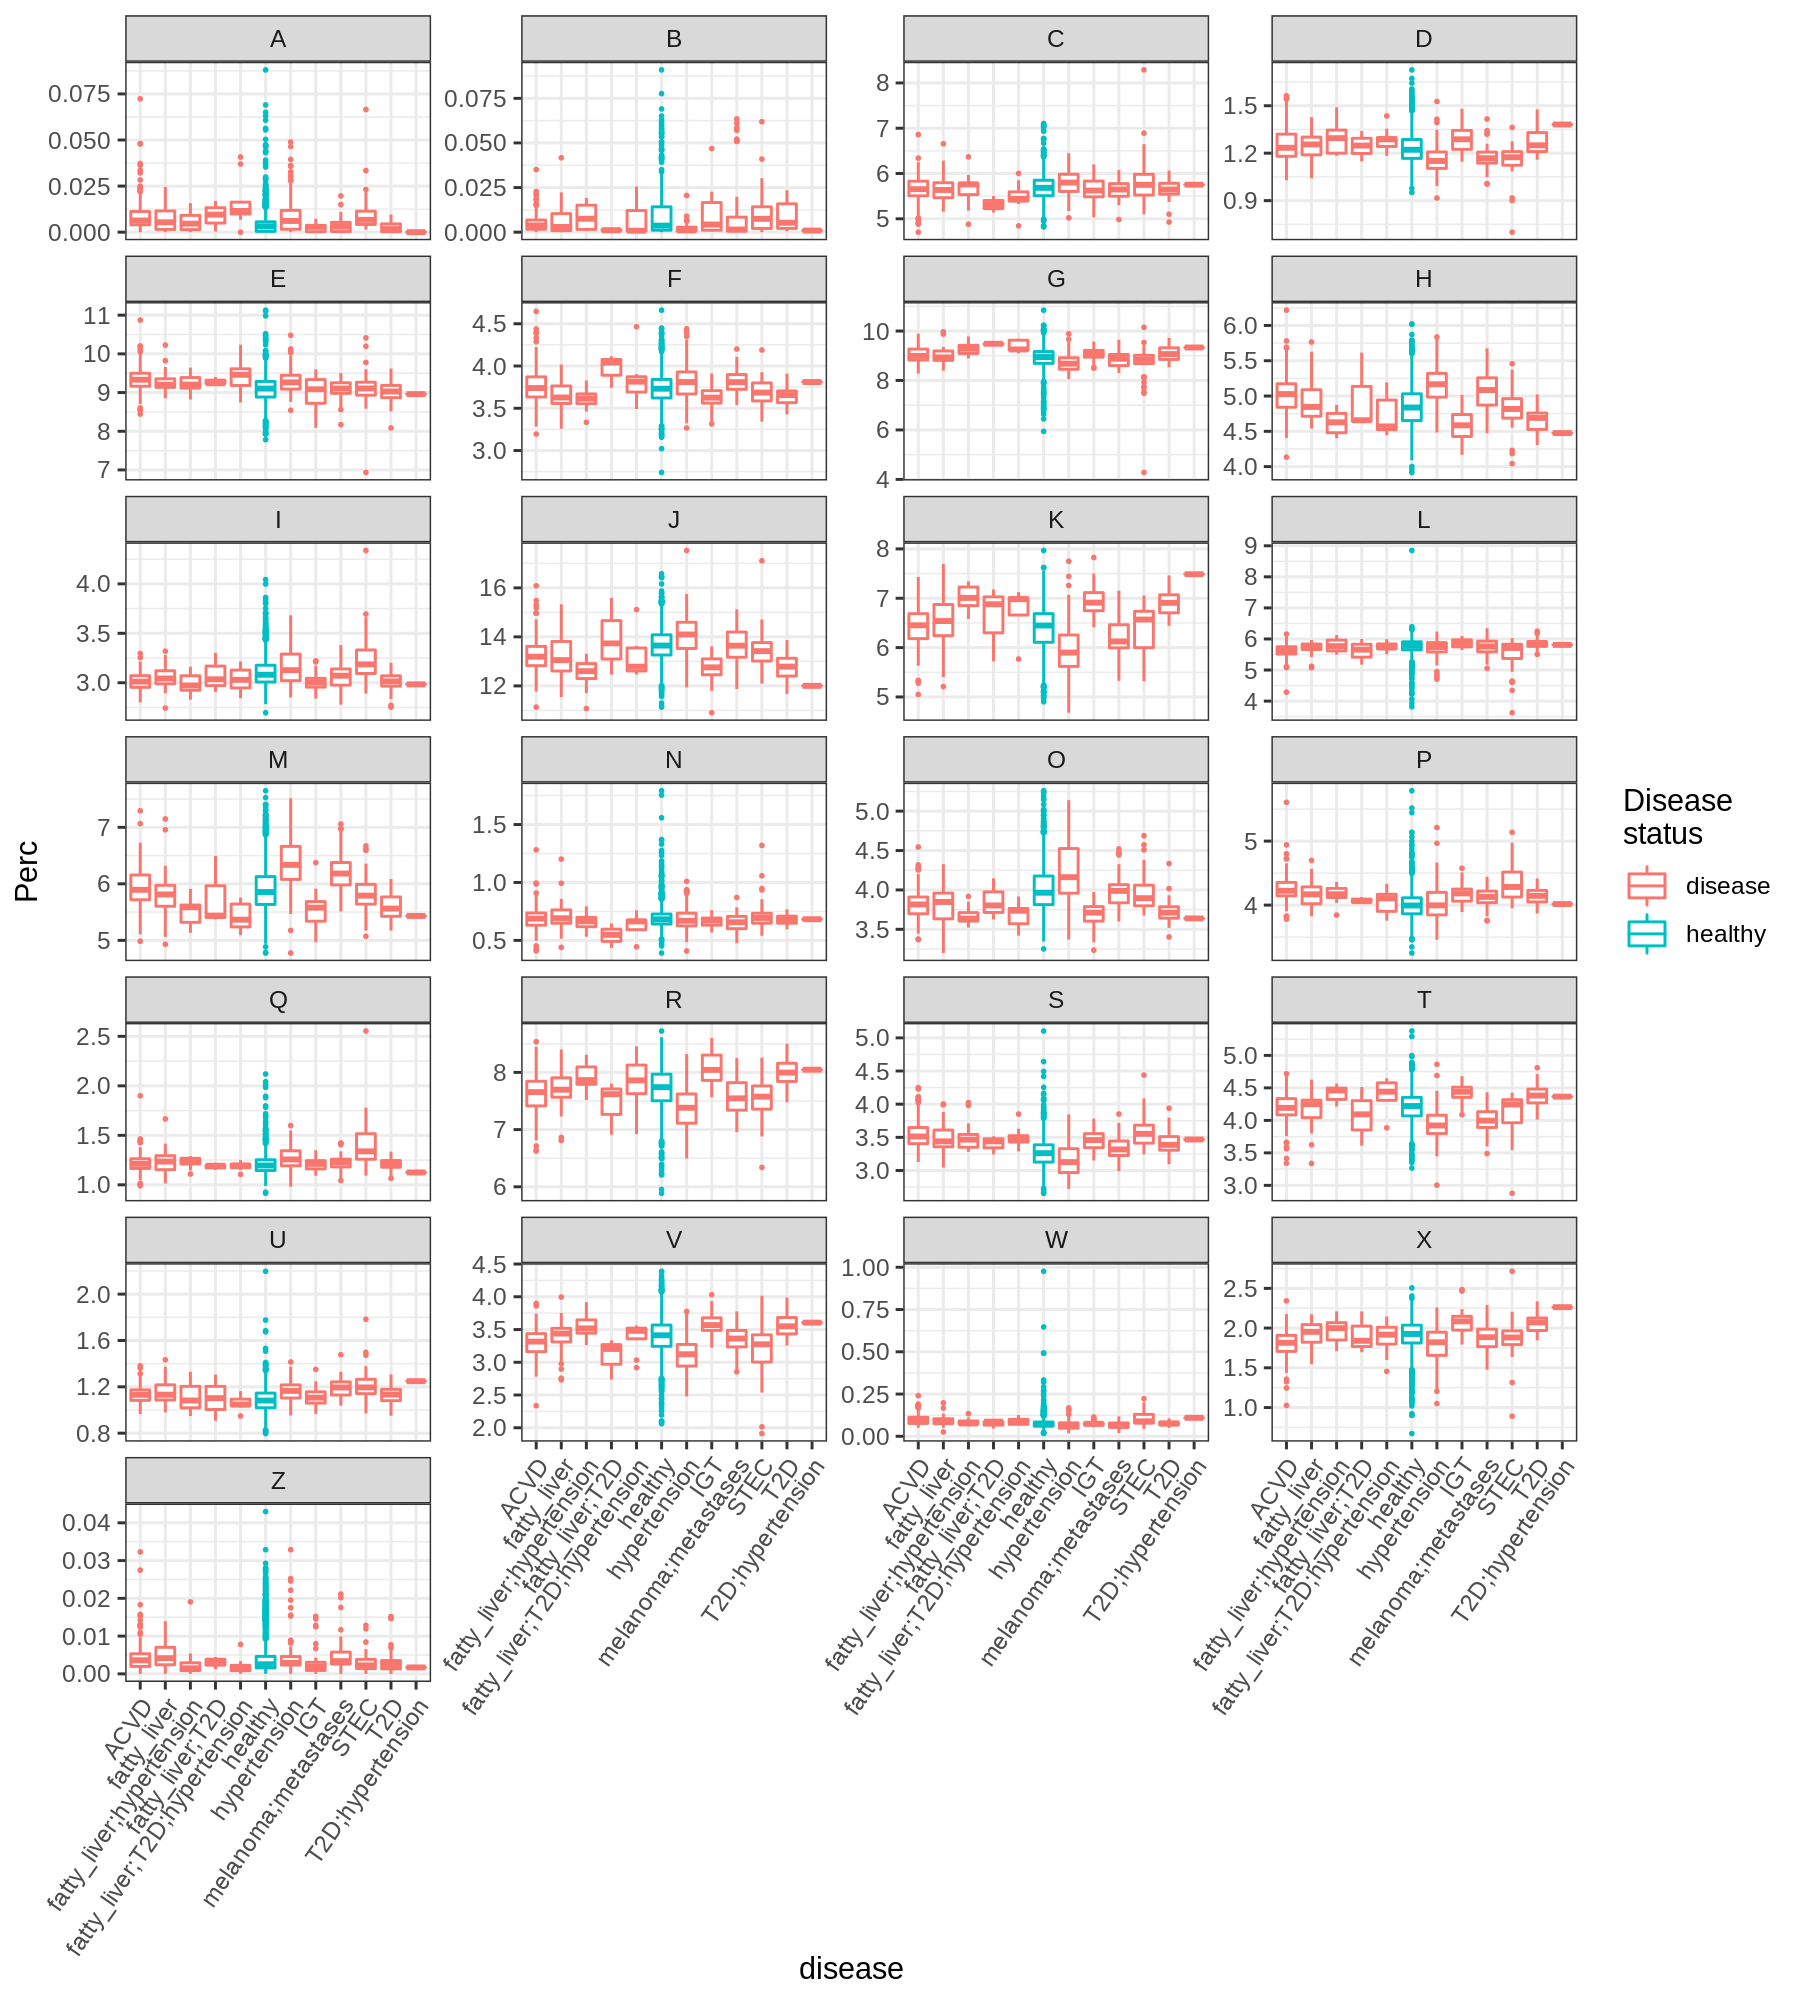

In [57]:
# plotting
p = trt_s %>%
    mutate.(disease_status = ifelse(disease == 'healthy', 'healthy', 'disease')) %>%
    ggplot(aes(disease, Perc, color=disease_status)) +
    geom_boxplot(outlier.size=0.3) +
    scale_color_discrete('Disease\nstatus') +
    facet_wrap(~ COG_cat, scales='free_y', ncol=4) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=55, hjust=1)
    )
p.dims(9,10)
plot(p)

In [70]:
# summarizing
trt_s = trt %>%
    mutate.(disease_status = ifelse(disease == 'healthy', 'healthy', 'disease')) %>%
    summarize.(Count = mean(Count),
               Perc = mean(Perc),
               .by=c(COG_cat, Sample, disease_status)) 
summary_x(trt_s$Perc)

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,sd,sd_err_of_mean
Perc,0,1.159644,3.706802,3.998325,5.787738,17.52524,6.311,2.576


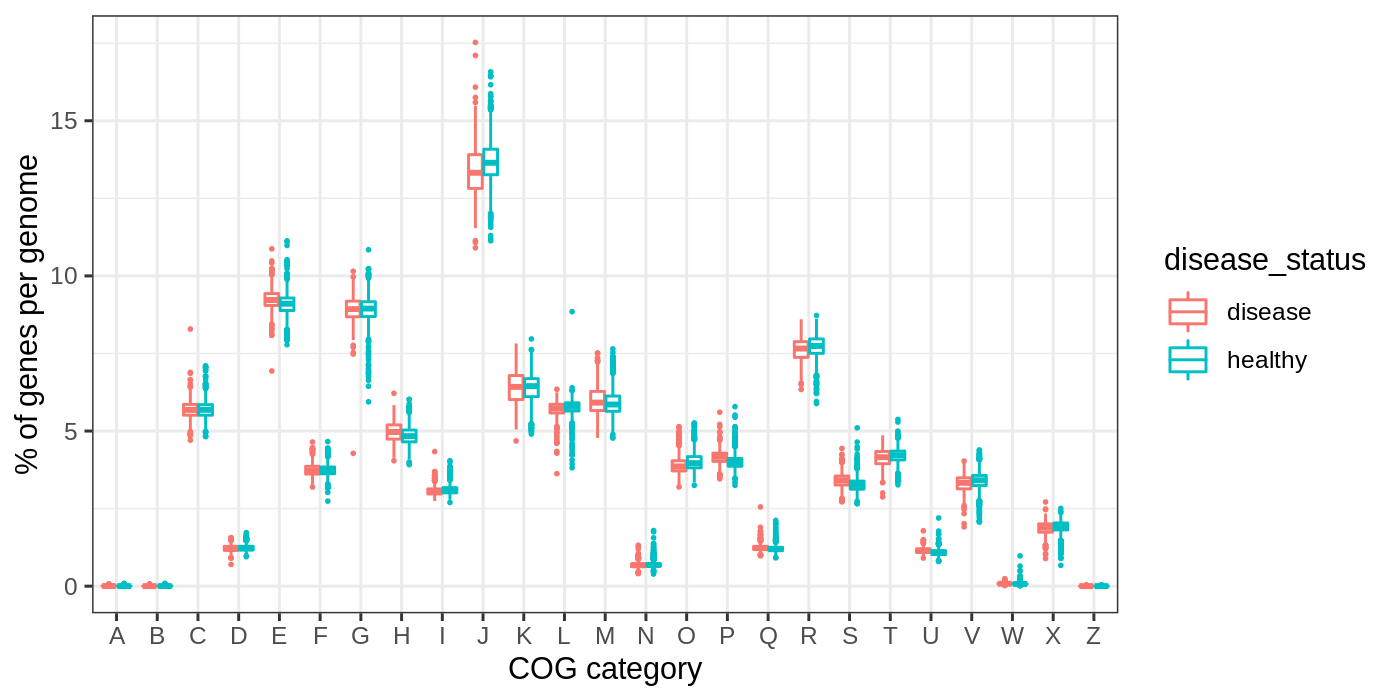

In [65]:
# plotting
p = trt_s %>%
    ggplot(aes(COG_cat, Perc, color=disease_status)) +
    geom_boxplot(outlier.size=0.3) +
    labs(x='COG category', y='% of genes per genome') +
    theme_bw() 
p.dims(7,3.5)
plot(p)

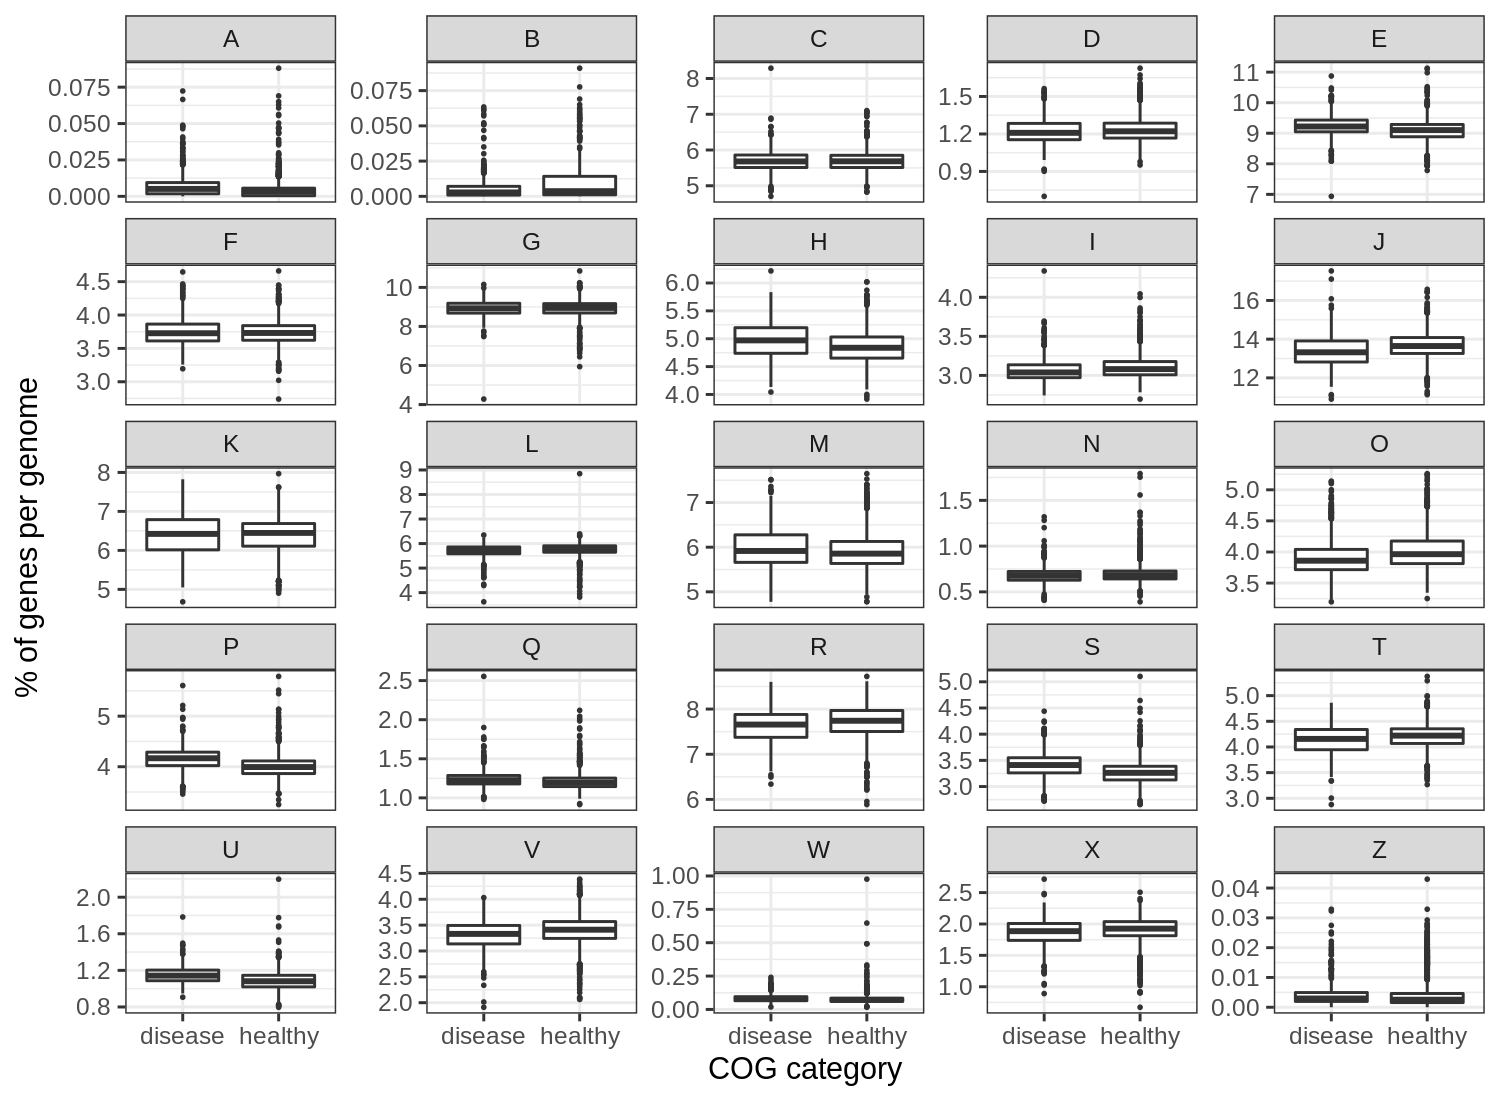

In [69]:
# plotting
p = trt_s %>%
    ggplot(aes(disease_status, Perc)) +
    geom_boxplot(outlier.size=0.3) +
    labs(x='COG category', y='% of genes per genome') +
    facet_wrap(~ COG_cat, scales='free_y') +
    theme_bw() 
p.dims(7.5,5.5)
plot(p)

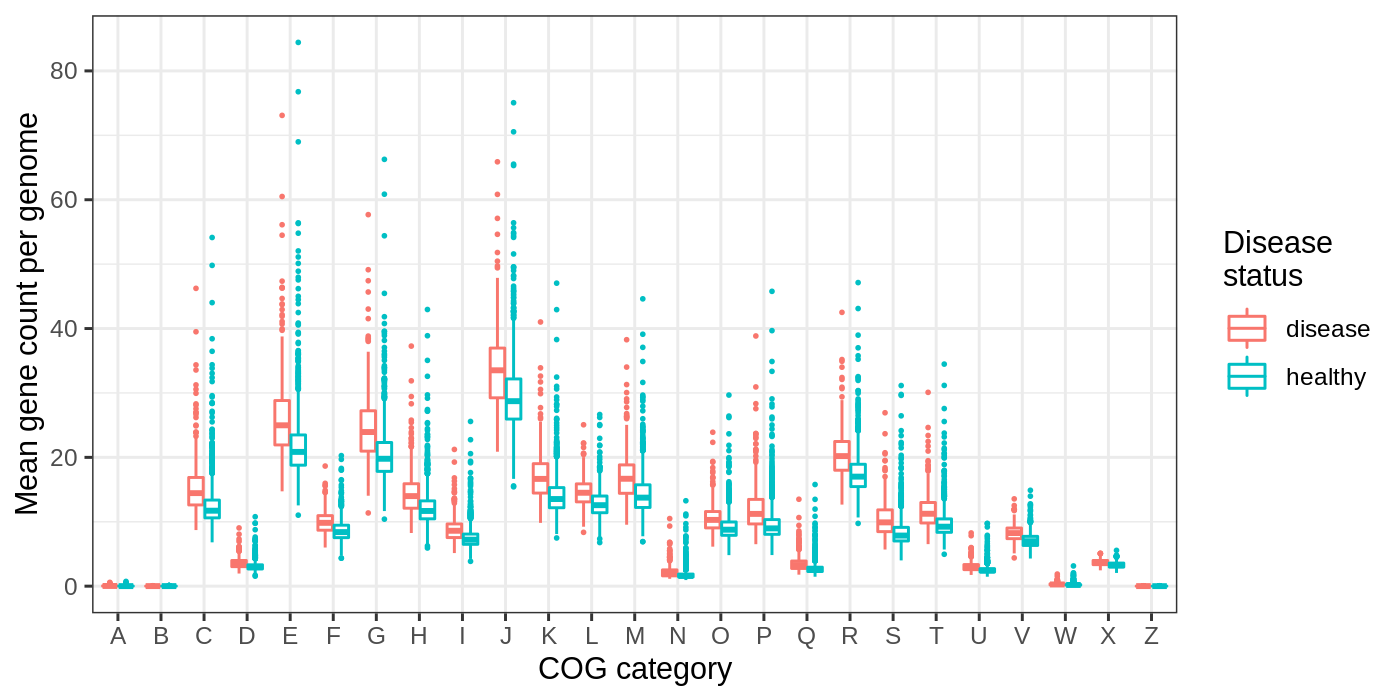

In [73]:
# plotting
p = trt_s %>%
    ggplot(aes(COG_cat, Count, color=disease_status)) +
    geom_boxplot(outlier.size=0.3) +
    scale_color_discrete('Disease\nstatus') +
    labs(x='COG category', y='Mean gene count per genome') +
    theme_bw() 
p.dims(7,3.5)
plot(p)

In [106]:
# stats
wilcox_test = function(df){
    res = wilcox.test(Count ~ disease_status, data=df)
    df = data.frame(stat = res$statistic,
                    pval = res$p.value,
                    COG_cat = df$COG_cat %>% unique)
    return(df)
}
trt_ss = trt_s %>%
    group_split.(COG_cat) %>%
    lapply(wilcox_test) %>%
    rbindlist() %>%
    mutate.(pval = pval %>% as.Num,
            qval = pval %>% p.adjust(method='BH')) %>%
    mutate.(sig = case_when.(qval < 1e-10 ~ '***',
                             qval < 1e-5 ~ '**', 
                             qval < 1e-2 ~ '*', 
                             TRUE ~ ''))
            
trt_ss

stat,pval,COG_cat,qval,sig
<dbl>,<dbl>,<chr>,<dbl>,<chr>
765594.5,1.803249e-37,A,1.960053e-37,***
564233.0,6.185659e-01,B,6.185659e-01,
⋮,⋮,⋮,⋮,⋮
836708,3.566553e-68,X,6.368845e-68,***
699395,4.186520e-17,Z,4.360959e-17,***


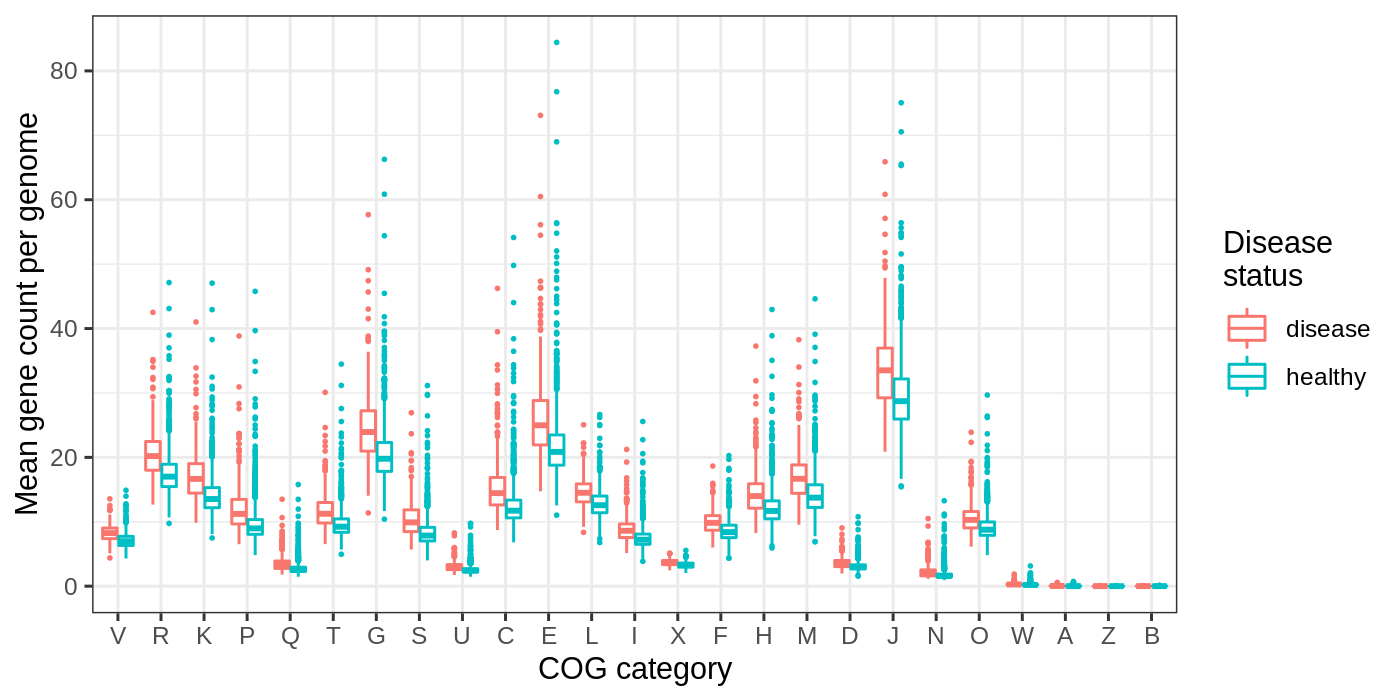

In [108]:
# plotting
p = trt_s %>%
    inner_join.(trt_ss, c('COG_cat')) %>%
    mutate.(COG_cat = COG_cat %>% reorder(-stat)) %>%
    ggplot(aes(COG_cat, Count)) +
    geom_boxplot(aes(color=disease_status), outlier.size=0.3) +
    #geom_text(aes(label=sig, y=90), data=trt_ss) +
    scale_color_discrete('Disease\nstatus') +
    labs(x='COG category', y='Mean gene count per genome') +
    theme_bw() 
p.dims(7,3.5)
plot(p)

# sessionInfo

In [109]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects2/global_metagenome_diversity/envs/phyloseq/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] LeyLabRMisc_0.2.0 ape_5.5           tidytable_0.6.5   data.table_1.14.0
[5] ggplot2_3.3.5     tidyr_1.1.3       dplyr_1.0.7      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7           pillar_1.6.2         compiler_4.1.1      
 [4] qs_0.25.1            base6